In [10]:
### quantization
## steps: 1 -> Determine the bin width
## 2 -> a) clamp the input (validaiton of input), so that it doesn't pass through the range
## b) if you have fixed the bit_size, then use the bin width function to create the bin width
## c) use min max normalisation function with denominator as bin width instead of range
## 3) finally clamp the output to the range in case it goes outside the range (this needs to be done on both sidex)

## 3-> now we need to dequantize the input
## a) again determine the bin width
## b) use the formula minval + s*m , where s is binwidth , m in your output value of quantization but there is big bug
## you need also to clamp the output on both sides
## for that you need to min(max(m,0), 2**bit_size - 1) this should be new m and feeded to b)

In [ ]:
## bin width  -5 ,  -10 10

-10 to 10
19 bins - 


In [1]:
def create_bin_width(minval, maxval, bit_size=3):
    return (maxval - minval) / 2**bit_size

def quantize(n, minval, maxval, bit_size):
    # 1. Clamp input
    n = min(max(n, minval), maxval)

    # 2. Compute scale
    s = create_bin_width(minval, maxval, bit_size)

    # 3. Compute bin index, you can think of below step as min max normalisation
    q = int((n - minval) / s)  # for clamped n this is >= 0

    # 4. Clamp output to [0, 2**bit_size - 1]
    q = min(q, 2**bit_size - 1)
    return q


def dequantize(m, minval, maxval, bit_size):
    s = create_bin_width(minval, maxval, bit_size)
    # clamp m to valid range
    m = min(max(m, 0), 2**bit_size - 1)
    return minval + s * m

In [12]:
quantize(15, -10, 10, 3)

7

In [13]:
dequantize(-2, -10, 10,3)

-10.0

In [14]:
quantize(-2, -10, 10,3)

3

In [15]:
dequantize(-100, -10, 10,3)

-10.0

In [ ]:
import torch

def create_bin_width(minval, maxval, bit_size=3):
    return (maxval - minval) / (2 ** bit_size)

def quantize_tensor(x, minval, maxval, bit_size):

    # 1. Clamp input elementwise
    x = torch.clamp(x, min=minval, max=maxval)

    # 2. Compute scale
    s = create_bin_width(minval, maxval, bit_size)

    # 3. Bin index (elementwise)
    q = torch.floor((x - minval) / s)

    # 4. Clamp bin indices to [0, 2^b - 1]
    q = torch.clamp(q, 0, 2 ** bit_size - 1)

    return q  # still a float tensor; you can do q.long() if you want integer bins

def dequantize_tensor(q, minval, maxval, bit_size):

    s = create_bin_width(minval, maxval, bit_size)

    # Optionally clamp q to valid range (safe)
    q = torch.clamp(q, 0, 2 ** bit_size - 1)

    return minval + s * q


In [ ]:
## Example

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Load image
img = Image.open("mars_rover.jpg").convert("L")  # "L" = grayscale; use "RGB" if you want color
img_np = np.array(img)   # shape: (H, W) or (H,W,3) for RGB
print(img_np.shape, img_np.dtype)  # should be uint8, values 0–255


(2400, 3000) uint8


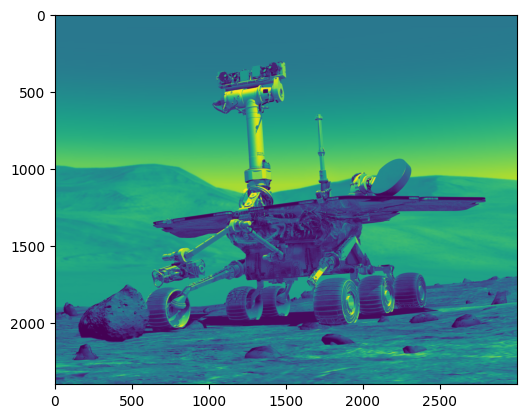

In [25]:
plt.imshow(img_np)

In [ ]:
img_t = torch.from_numpy(img_np).float()  # convert to float for quantizer


In [21]:
img_t = torch.from_numpy(img_np).float()  # convert to float for quantizer

In [22]:
bit_size = 3
quant = quantize_tensor(img_t, 0.0, 255.0, bit_size=bit_size)


# Dequantize: back to approximate pixel values
img_q_t = dequantize_tensor(quant, 0.0, 255.0, bit_size)


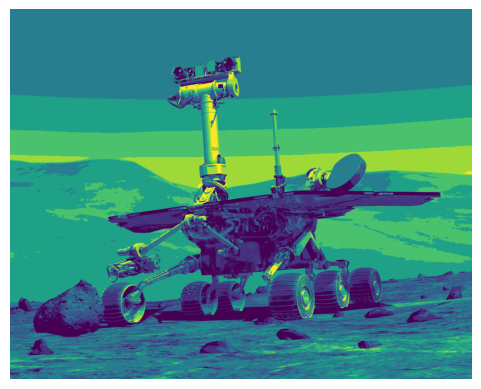

In [24]:
plt.imshow(img_q_t)
plt.axis("off")
plt.show()

In [ ]:
import torch
import numpy as np

def tensor_memory_bytes(x):
    return x.numel() * x.element_size()

# example image
img_np = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
img_t = torch.from_numpy(img_np).float()   # convert to float32

bit_size = 3

q = quantize_tensor(img_t, 0., 255., bit_size)
img_q_t = dequantize_tensor(q, 0., 255., bit_size)

print("Original NumPy:", img_np.nbytes, "bytes")
print("Original Tensor:", tensor_memory_bytes(img_t), "bytes")
print("Quantized Tensor:", tensor_memory_bytes(q), "bytes")
print("Dequantized Tensor:", tensor_memory_bytes(img_q_t), "bytes")

# Theoretical INT4 storage
print("Theoretical INT4 storage:", q.numel() * (bit_size / 8), "bytes")


Original NumPy: 65536 bytes
Original Tensor: 262144 bytes
Quantized Tensor: 262144 bytes
Dequantized Tensor: 262144 bytes
Theoretical INT4 storage: 24576.0 bytes


## Remember: There is NO native 4-bit or 2-bit tensor in PyTorch today.

In [38]:
q_uint8 = quant.to(torch.uint8)
print(q_uint8.element_size())   # 1 byte = 256x256x1 byte
## Still same as numpy original image 
## PyTorch cannot store 3-bit tensors (but QNNPACK backend internally can).So the optimization actually happens not in pytorch but in backend which is connected to tensorrt

1


In [37]:
256*256

65536

PyTorch has:

    torch.quantization

    torch.ao.quantization

    quantize_dynamic, prepare, convert


But these run on CPU-only backends like:

    QNNPACK

    FBGEMM

And they do NOT generate real INT4/INT2 kernels.

GPU acceleration = only via TensorRT.
TensorRT is NVIDIA’s official PyTorch -> TensorRT compiler

PyTorch is for model building + training + fake quantization
TensorRT is for real quantization + kernel fusion + INT8/INT4 acceleration
The optimization happens in TensorRT, not inside PyTorch. It allows us to compile a PyTorch model directly into a TensorRT engine without manually exporting to ONNX.